# vit_step2e_SiglipVisionEmbeddings_deliberate_wrong_implementation4.ipynb
- 
<span style="color: red"> SiglipVisionConfig has been deliberately changed to keep 758 as the embedding_dim instead of 768. </span>
- But there is no error in the implementation of SiglipVisionEmbeddings
- Despite the only change being in SiglipVisionConfig, this creates some challenges in loading the hugging face weights
- See comparison of our-embeddings-output vs hugging-face-embeddings-output section for more insights

## Imports
These are some preliminary imports that are needed. \
Some other imports for HF output are imported later to prevent confusion in understanding between HFSiglipVisionConfig vs our custom defined SiglipVisionConfig etc.

In [1]:
import torch
from torch import nn
from torchvision import transforms
from dataclasses import dataclass
from PIL import Image

## Image + Preprocess Image

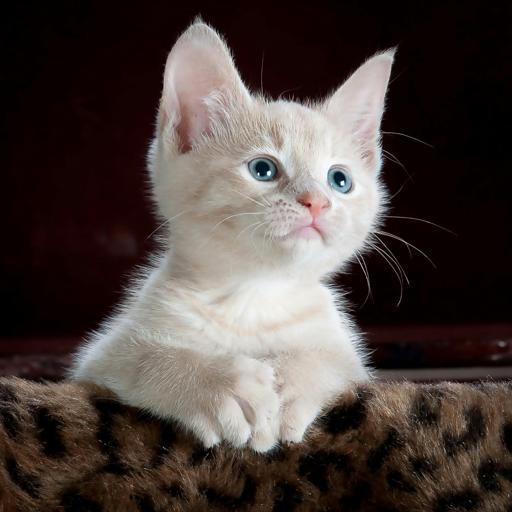

In [2]:
def preprocess_image(image, image_size=224):
    # define the preprocess operation
    preprocess = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std =[0.229, 0.224, 0.225]
        )
    ])

    # actually preprocess the image
    image_tensor = preprocess(image)
    #(3,224,224) --> unsqueeze -->(1,3,224,224)
    image_tensor = image_tensor.unsqueeze(0)
    return image_tensor

img = Image.open("image.jpg")
img

In [3]:
image_tensor = preprocess_image(img)

## SiglipVisionConfig
<span style="color: red"> hidden_size has been changed from 768 to 758 </span>

In [4]:
'''
@dataclass is a decorator in Python that automatically generates special methods like __init__, __repr__, and __eq__ for a class. 
This simplifies the creation of classes primarily used for storing data. 
It reduces boilerplate code and improves readability, especially when dealing with objects that mainly hold data.
'''
@dataclass
class SiglipVisionConfig:
    image_size: int = 224
    patch_size: int = 16
    hidden_size: int = 768-10
    num_channels: int = 3


## SiglipVisionEmbeddings
Standard/ Correct implementation of SiglipVisionEmbeddings. No error/ bugs in SiglipVisionEmbeddings

In [5]:
class SiglipVisionEmbeddings(nn.Module):
    
    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.config = config    

        self.image_size   = config.image_size
        self.patch_size   = config.patch_size                
        self.embed_dim   = config.hidden_size # same as embedding size
        self.num_channels = config.num_channels
    
        # Patch embedding Layer: 
        # This is just a convolution layer of the patch size with kernel size same as patch size
        # Example: For patch_size = 16, This is a convolution of kernel size: 16*16 and stride 16
        # The input to this is an image tensor (see forward)
        self.patch_embedding = nn.Conv2d(
            in_channels  = self.num_channels,
            out_channels = self.embed_dim,
            kernel_size  = self.patch_size,
            stride=self.patch_size,
            padding = "valid" # same as no padding
        )
    
        # // is floor division. ** is exponentiation. 
        # You square by 2 because you have patches along the length and breadth
        self.num_patches   = (self.image_size// self.patch_size)**2
        self.num_positions = self.num_patches
    
        # Position Embedding Layer. This is a lookup table 
        # The input to this is a bunch of position_ids and not an image tensor, see forward        
        self.position_embedding = nn.Embedding(self.num_positions, self.embed_dim)
    
        # Register Buffer/ Position ids
        # registers a non-trainable buffer called position_ids in a nn.Module subclass (so this creates self.position_ids)
        # self.position_ids, which will be a tensor of shape [1, num_patches]
        self.register_buffer(
            "position_ids",
            torch.arange(self.num_positions).expand((1,-1)),
            persistent=False, # this is a buffer, so it won't be updated during the forward pass
        )
        
    def forward(self, pixel_values: torch.FloatTensor) -> torch.Tensor:
        # num_batches, num_channels, height, width
        B, C, H, W = pixel_values.shape
        # Patch embeddings
        patch_embeds = self.patch_embedding(pixel_values)
        flattened_patch_embeds = patch_embeds.flatten(start_dim=2, end_dim=-1)
        flattened_patch_embeds = flattened_patch_embeds.transpose(1, 2)
        # Position embeddings
        position_embeds = self.position_embedding(self.position_ids)
        # Total Embeddings
        total_embeds = flattened_patch_embeds + position_embeds
        return total_embeds

## Compare Our Output vs HF Output
HF Outout uses default Vision Embeddings. \
Our Output uses our custom Vision Embeddings: SiglipVisionEmbeddings. 

### i) Sanity Check Our-Embeddings & Our-Embeddings-State-Dict
- Check the our_embeddings output shape . It should have the dimensions torch.Size([1, 196, 768])
- Also print the state_dict of our_embeddings. It should have the same keys as hf_state_dict.
  
our-embeddings-state-dict should have the following keys
- key: patch_embedding.weight
- key: patch_embedding.bias
- key: position_embedding.weight

In [6]:
# Our embeddings
our_embeds = SiglipVisionEmbeddings(SiglipVisionConfig())
print("our_embed(image_tensor).shape:", our_embeds(image_tensor).shape)

# State Dictionary of our embeddings
our_embeds_state_dict = our_embeds.state_dict()

print("\n--------our_embeds_state_dict: keys ---------")
for k, v in our_embeds_state_dict.items() :
    print("key:", k)

our_embed(image_tensor).shape: torch.Size([1, 196, 758])

--------our_embeds_state_dict: keys ---------
key: patch_embedding.weight
key: patch_embedding.bias
key: position_embedding.weight


### ii) Load Hugging Face : SiglipVisionModel . Observer the layers

In [7]:
from transformers import SiglipVisionModel as HFSiglipVisionModel
from transformers import SiglipVisionConfig as HFSiglipVisionConfig

# HF output and HF State dictionary
hf_vision_model = HFSiglipVisionModel.from_pretrained("google/siglip-base-patch16-224", 
                                                      config=HFSiglipVisionConfig(vision_use_head=False))
hf_vision_model

SiglipVisionModel(
  (vision_model): SiglipVisionTransformer(
    (embeddings): SiglipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), padding=valid)
      (position_embedding): Embedding(196, 768)
    )
    (encoder): SiglipEncoder(
      (layers): ModuleList(
        (0-11): 12 x SiglipEncoderLayer(
          (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attn): SiglipAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): SiglipMLP(
            (activation_fn): PytorchGELUTanh()
            (fc1): Linear(in_features=768, out_features=3072, 

### iii) Load Hugging Face : SiglipVisionModel's Entire State Dict. Observe all the keys

In [8]:
print("\n --------hf_vision_model: all the key names in state_dict---------\n")
for k, v in hf_vision_model.state_dict().items() :
    print("key:", k)
        
print("\n\n--------hf_vision_model: only the keys beginning with vision_model.embeddings ---------")
print("So this would be the hf_embeds_state_dict keys: before updating the key names \n")
for k, v in hf_vision_model.state_dict().items() :
    if "vision_model.embeddings." in k:
        print("key:", k)


 --------hf_vision_model: all the key names in state_dict---------

key: vision_model.embeddings.patch_embedding.weight
key: vision_model.embeddings.patch_embedding.bias
key: vision_model.embeddings.position_embedding.weight
key: vision_model.encoder.layers.0.layer_norm1.weight
key: vision_model.encoder.layers.0.layer_norm1.bias
key: vision_model.encoder.layers.0.self_attn.k_proj.weight
key: vision_model.encoder.layers.0.self_attn.k_proj.bias
key: vision_model.encoder.layers.0.self_attn.v_proj.weight
key: vision_model.encoder.layers.0.self_attn.v_proj.bias
key: vision_model.encoder.layers.0.self_attn.q_proj.weight
key: vision_model.encoder.layers.0.self_attn.q_proj.bias
key: vision_model.encoder.layers.0.self_attn.out_proj.weight
key: vision_model.encoder.layers.0.self_attn.out_proj.bias
key: vision_model.encoder.layers.0.layer_norm2.weight
key: vision_model.encoder.layers.0.layer_norm2.bias
key: vision_model.encoder.layers.0.mlp.fc1.weight
key: vision_model.encoder.layers.0.mlp.fc1.b

### iv) Specifically only extract the embeddings values and dictionary from hugging face model.
###     Update the hf_embeds_state_dict key names to be the same as our_embeds_state_dict
Notice that we don't really care about the entire hf_vision_model's state dictionary. \
We only care about the subset of the state dictionary related to the embeddings. \
Hence it is more appropriate to call the dictionary hf_embeds_state_dict. 

Rename the following keys i.e. the prefix vision_model.embeddings will be dropped
- vision_model.embeddings.patch_embedding.weight -> patch_embedding.weight
- vision_model.embeddings.patch_embedding.bias -> patch_embedding.bias
- vision_model.embeddings.position_embedding.weight -> position_embedding.weight 


In [9]:
# Update hf_embeds_state_dict keys
hf_embeds_state_dict = {k.replace("vision_model.embeddings.", ""): v \
                 for k, v in hf_vision_model.state_dict().items() if "vision_model.embeddings." in k}

print("\n\n--------hf_embeds_state_dict keys: after updating their names ---------\n")
for k, v in hf_embeds_state_dict.items() :
    print("key:", k)



--------hf_embeds_state_dict keys: after updating their names ---------

key: patch_embedding.weight
key: patch_embedding.bias
key: position_embedding.weight


### v) Update our_embeds_state_dict with key & value pairs from hf_embeds_state_dict
**does the following**
- It updates the dictionary our_embeds_state_dict in-place with the key-value pairs from hf_embeds_state_dict.
- So this effectively translates to loading the structure of the layers and their weights from hugging-face-embeddings to our embeddings implementation. This might seem supefluous. After all what is the point defining the conv2d layers and nn.Embedding etc.
- The point is, doing this allows us the to check the **def forward** implementation of the SiglipEmbeddings. If sth is wrong there , then this would catch the wrong implementation.
- See vit_step2b ... vit_ste2c, vit_step2d..._wrong_implementation to understand this better

**So specifically**
- our_embeds_state_dict is the state dict of the embedding layer from our custom model.
- hf_embeds_state_dict is the state dict of the pretrained Hugging Face model embedding layer.

**What happens**
- Each key in hf_embeds_state_dict that matches or is new to our_embeds_state_dict will be added or **overwritten.**
- This allows you to initialize or partially load **weights of only the embeddings** from the Hugging Face model into our own embeddings

In [10]:
our_embeds_state_dict.update(hf_embeds_state_dict)
print("\n--------our_embeds_state_dict: keys ---------")
for k, v in our_embeds_state_dict.items() :
    print("key:", k)




--------our_embeds_state_dict: keys ---------
key: patch_embedding.weight
key: patch_embedding.bias
key: position_embedding.weight


### vi) Update our-embeddings with our_embeds_state_dict (which has the hugging face weights for the embeddings only) 
Notice that our_embeds and our_embeds_state_dict are two different things
- in the previous step we loaded the layers and weights from hugging-face-model-embeddings to our_embeds_state_dict
- in this step we load the layers and weights from our_embeds_state_dict to our_embeds
- 
<span style="color: red"> This step is expected to error out. 
I deliberately changed the hidden dimension size to 758. But hugging face is only able to load weights with a dimension of 768.
</span>

🔍 What's Going Wrong?
**Your model expects**
- patch_embedding.weight: [758, 3, 16, 16]
- patch_embedding.bias: [758]
- position_embedding.weight: [196, 758]

But the checkpoint has:
- patch_embedding.weight: [768, 3, 16, 16]
- patch_embedding.bias: [768]
- position_embedding.weight: [196, 768]

This means your custom model uses embed_dim = 758, but the Hugging Face model uses embed_dim = 768.

<div style="background-color:#ffe5e5; padding:10px;">
RuntimeError: Error(s) in loading state_dict for SiglipVisionEmbeddings:

    size mismatch for patch_embedding.weight: copying a param with shape torch.Size([768, 3, 16, 16]) from checkpoint, the shape in current model is torch.Size([758, 3, 16, 16]).
    
	size mismatch for patch_embedding.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([758]).
    
	size mismatch for position_embedding.weight: copying a param with shape torch.Size([196, 768]) from checkpoint, the shape in current model is torch.Size([196, 758]).
    
</div>

In [11]:
our_embeds.load_state_dict(our_embeds_state_dict)

RuntimeError: Error(s) in loading state_dict for SiglipVisionEmbeddings:
	size mismatch for patch_embedding.weight: copying a param with shape torch.Size([768, 3, 16, 16]) from checkpoint, the shape in current model is torch.Size([758, 3, 16, 16]).
	size mismatch for patch_embedding.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([758]).
	size mismatch for position_embedding.weight: copying a param with shape torch.Size([196, 768]) from checkpoint, the shape in current model is torch.Size([196, 758]).

### vii) Final Step: Get the difference between the our-embeddings output and hugging-face-embeddings output
<span style="color: red"> It is not expected to reach this cell, it will error out sooner  </span >

In [ ]:
# Difference between hf_output and our_output
with torch.no_grad():
    our_output = our_embeds(image_tensor)
    hf_output = hf_vision_model.vision_model.embeddings(image_tensor)
    print("Max difference between our output and HF output:", torch.max(torch.abs(our_output - hf_output))) # =0, so they match!


## ✅ Rectifying errors
### ✅ Option 1: Fix the SiglipVisionConfig embedding dimension to 758.
We are not interested in this ! This would be trivial !

### ✅ Option 2: Replace Your Custom Layer with a 768 layer from Hugging Face 🤗
This would rectify errors
<div style="background-color:#C1FFC1; padding: 5px;">
# Expected Output   
    
Max difference between our output2 and HF output: tensor(0.)
</div>

In [ ]:
our_embeds2 = SiglipVisionEmbeddings(SiglipVisionConfig())

# Get pretrained patch_embedding and position_embedding
pretrained_patch_embedding = hf_vision_model.vision_model.embeddings.patch_embedding
pretrained_position_embedding = hf_vision_model.vision_model.embeddings.position_embedding

# Overwrite your model's patch_embedding with it
our_embeds2.patch_embedding = pretrained_patch_embedding
our_embeds2.position_embedding = pretrained_position_embedding

# Then proceed with the rest as usual
# Difference between hf_output and our_output
with torch.no_grad():
    our_output2 = our_embeds2(image_tensor)
    hf_output = hf_vision_model.vision_model.embeddings(image_tensor)
    print("Max difference between our output2 and HF output:", torch.max(torch.abs(our_output2 - hf_output))) # =0, so they match!


### ✅ Option 3: Truncate pretrained weights (if you must use 758)
This would rectify errors
<div style="background-color:#C1FFC1; padding: 5px;">
# Expected Output   
    
Max difference between our output3 and HF output(model truncated to 758): tensor(0.)
</div>

In [ ]:
our_embeds3 = SiglipVisionEmbeddings(SiglipVisionConfig())

# Get pretrained patch_embedding and position_embedding
pretrained_patch_embedding = hf_vision_model.vision_model.embeddings.patch_embedding
pretrained_position_embedding = hf_vision_model.vision_model.embeddings.position_embedding

# Truncated Weights from Hugging Face
pretrained_truncated_patch_weight = pretrained_patch_embedding.weight[:758, :, :, :]
pretrained_truncated_patch_bias   = pretrained_patch_embedding.bias[:758]
pretrained_truncated_position_weight = pretrained_position_embedding.weight[:,:758]

'''
In PyTorch, a leaf variable is a tensor that:
- Was created by the user (not the result of a computation)
- And has requires_grad=True.
Model parameters (like .weight, .bias) are leaf variables by default.

Trying to do an in-place modification (like .copy_()) on a tensor that is a leaf node in the computation graph 
which has requires_grad=True, without disabling gradient tracking, would be wrong.

Hence the need for with torch.no_grad()
'''
with torch.no_grad():
    # Overwrite our model's patch_embedding with trained , truncated weights from Hugging Face
    our_embeds3.patch_embedding.weight.copy_(pretrained_truncated_patch_weight)
    our_embeds3.patch_embedding.bias.copy_(pretrained_truncated_patch_bias)
    our_embeds3.position_embedding.weight.copy_(pretrained_truncated_position_weight)
    
# Overwrite hf_vision_model's patch_embedding with trained , truncated weights from Hugging Face 
# We would need this so that both our_embeds2 ans hf_ouput are both truncated to 758
# HF output and HF State dictionary
hf_truncated_vision_model = HFSiglipVisionModel.from_pretrained("google/siglip-base-patch16-224", 
                                                      config=HFSiglipVisionConfig(vision_use_head=False))
hf_truncated_vision_model.vision_model.embeddings.patch_embedding = our_embeds3.patch_embedding
hf_truncated_vision_model.vision_model.embeddings.position_embedding = our_embeds3.position_embedding

with torch.no_grad():
    # Then proceed with the rest as usual
    # Difference between hf_output and our_output
    our_output3 = our_embeds3(image_tensor)
    hf_truncated_output = hf_truncated_vision_model.vision_model.embeddings(image_tensor)
    print("Max difference between our output3 and HF Truncated output(model truncated to 758):", torch.max(torch.abs(our_output3 - hf_truncated_output))) # =0, so they match!
